## Competition link:<a href="https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price">Prediction interval competition II: House price</a>
## Created by <a href="https://github.com/yunsuxiaozi">yunsuxiaozi</a> 2025/06/12

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">1.Import Libraries</h1></span>

Due to the continuous updates of the <a href="https://github.com/yunsuxiaozi/Yunbase">Yunbase</a> GitHub repository, a static version is used <a href="https://www.kaggle.com/code/yunsuxiaozi/yunbase">here</a>.We are using version 22 here.

This is a framework I developed for the convenience of playing competitions and avoiding writing duplicate code. You can simply understand it as automl, although its current performance is not as good as automl.

If you are not familiar with `Yunbase`, it's okay. Yunbase mainly encapsulates some commonly used operations such as `onehotencoder`、`kfold`, You can also manually implement the same function without using Yunbase. This notebook mainly provides beginners with some ideas for feature engineering and cross validation.

If there is a long time, such as a month or even a year, after the release date of this notebook, this code may not be able to run directly.Since the version of `Yunbase` will be constantly updated, if you want to run this code successfully, you might first download the output from the corresponding version in <a href="https://www.kaggle.com/code/yunsuxiaozi/yunbase">Yunbase</a>, save it as your own dataset, and then import it.

In [1]:
source_file_path = '/kaggle/input/yunbase/Yunbase/baseline.py'
target_file_path = '/kaggle/working/baseline.py'
with open(source_file_path, 'r', encoding='utf-8') as file:
    content = file.read()
with open(target_file_path, 'w', encoding='utf-8') as file:
    file.write(content)

In [2]:
!pip install -q --requirement /kaggle/input/yunbase/Yunbase/requirements.txt  \
--no-index --find-links file:/kaggle/input/yunbase/

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.7.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.1 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompati

In [3]:
from baseline import Yunbase
import pandas as pd#read csv,parquet
import numpy as np#for scientific computation of matrices
from  lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer#word2vec feature
import warnings#avoid some negligible errors
#The filterwarnings () method is used to set warning filters, which can control the output method and level of warning information.
warnings.filterwarnings('ignore')
import random#provide some function to generate random_seed.
#set random seed,to make sure model can be recurrented.
def seed_everything(seed):
    np.random.seed(seed)#numpy's random seed
    random.seed(seed)#python built-in random seed
seed_everything(seed=2025)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">2.Load data</h1></span>



In [4]:
drop_cols=['id',#row_id,没有任何信息.
           'golf',#20万数据 198756都是0,基本没什么信息了.
           'view_rainier',#20万数据,198588都是0.
           'view_skyline',#20万数据,198517都是0.
           'view_lakesamm',#20万数据,198776都是0.
           'view_otherwater',#20万数据,198473都是0.
           'view_other',#20万数据,198833都是0.
          ]
train=pd.read_csv("/kaggle/input/prediction-interval-competition-ii-house-price/dataset.csv").drop(drop_cols,axis=1)
test=pd.read_csv("/kaggle/input/prediction-interval-competition-ii-house-price/test.csv").drop(drop_cols,axis=1)
train.head()

,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,city,...,gara_sqft,wfnt,greenbelt,noise_traffic,view_olympics,view_cascades,view_territorial,view_sound,view_lakewash,submarket
0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,FEDERAL WAY,...,500,0,0,0,0,0,0,0,0,I
1,1999-01-15,313300,NaN,26,nochg,2025,47.6531,-122.1996,74,KIRKLAND,...,0,0,0,0,0,0,0,0,1,Q
2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,RENTON,...,480,0,0,0,0,0,0,0,0,K
3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,BURIEN,...,530,0,0,1,0,0,0,0,0,G
4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,KING COUNTY,...,810,0,0,0,0,0,0,0,0,P


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">3.Feature Engineer</h1></span>

The feature engineering done here is relatively simple.

In [5]:
pd.set_option('display.max_columns',100)
NUMS=['area','land_val','imp_val','sqft_lot','sqft','sqft_1','sqft_fbsmt','garb_sqft','gara_sqft']
def FE(df):
    for i in range(len(NUMS)):
        for j in range(i+1,len(NUMS)):
            df[f'{NUMS[i]}_x_{NUMS[j]}']=df[NUMS[i]]*df[NUMS[j]]
    df['year']=df['sale_date'].apply(lambda x:int(x.split("-")[0]))
    df['month']=df['sale_date'].apply(lambda x:int(x.split("-")[1]))
    
    df['year_gap']=df['join_year']-df['year']
    df['year_diff']=df['year']-df['year_built']
    df['total_view1']=0
    for c in [c for c in df.columns if 'view' in c]:
        df['total_view1']+=df[c]

    for c in ['land_val_x_imp_val', 'land_val_x_sqft',  'imp_val_x_sqft']:
        df[c]=np.log1p(df[c])
    return df
train=FE(train).drop_duplicates().reset_index(drop=True)
test=FE(test)
train.head()

,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,city,zoning,subdivision,present_use,land_val,imp_val,year_built,year_reno,sqft_lot,sqft,sqft_1,sqft_fbsmt,grade,fbsmt_grade,condition,stories,beds,bath_full,bath_3qtr,bath_half,garb_sqft,gara_sqft,wfnt,greenbelt,noise_traffic,view_olympics,view_cascades,view_territorial,view_sound,view_lakewash,submarket,area_x_land_val,area_x_imp_val,area_x_sqft_lot,area_x_sqft,area_x_sqft_1,area_x_sqft_fbsmt,area_x_garb_sqft,area_x_gara_sqft,land_val_x_imp_val,land_val_x_sqft_lot,land_val_x_sqft,land_val_x_sqft_1,land_val_x_sqft_fbsmt,land_val_x_garb_sqft,land_val_x_gara_sqft,imp_val_x_sqft_lot,imp_val_x_sqft,imp_val_x_sqft_1,imp_val_x_sqft_fbsmt,imp_val_x_garb_sqft,imp_val_x_gara_sqft,sqft_lot_x_sqft,sqft_lot_x_sqft_1,sqft_lot_x_sqft_fbsmt,sqft_lot_x_garb_sqft,sqft_lot_x_gara_sqft,sqft_x_sqft_1,sqft_x_sqft_fbsmt,sqft_x_garb_sqft,sqft_x_gara_sqft,sqft_1_x_sqft_fbsmt,sqft_1_x_garb_sqft,sqft_1_x_gara_sqft,sqft_fbsmt_x_garb_sqft,sqft_fbsmt_x_gara_sqft,garb_sqft_x_gara_sqft,year,month,year_gap,year_diff,total_view1
0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,FEDERAL WAY,RS7.2,ALDERWOOD SOUTH DIV NO. 02,2,167000,372000,1975,0,10919,1560,1560,0,7,0,5,1.0,3,1,1,0,0,500,0,0,0,0,0,0,0,0,I,8851000,19716000,578707,82680,82680,0,0,26500,24.852398,1823473000,19.378190,260520000,0,0,83500000,4061868000,20.179090,580320000,0,0,186000000,17033640,17033640,0,0,5459500,2433600,0,0,780000,0,0,780000,0,0,0,2014,11,11,39,0
1,1999-01-15,313300,NaN,26,nochg,2025,47.6531,-122.1996,74,KIRKLAND,RS 8.5,WILDWOOD LANE NO. 03,2,1184000,598000,1962,0,8900,2040,1220,820,7,7,4,1.0,3,1,1,1,0,0,0,0,0,0,0,0,0,1,Q,87616000,44252000,658600,150960,90280,60680,0,0,27.285755,10537600000,21.605114,1444480000,970880000,0,0,5322200000,20.922051,729560000,490360000,0,0,18156000,10858000,7298000,0,0,2488800,1672800,0,0,1000400,0,0,0,0,0,1999,1,26,37,2
2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,RENTON,R-8,FALCON RIDGE (CEDAR RIDGE),2,230000,356000,1986,0,4953,1640,820,0,7,0,3,2.0,3,2,0,1,0,480,0,0,0,0,0,0,0,0,K,6900000,10680000,148590,49200,24600,0,0,14400,25.128521,1139190000,19.748286,188600000,0,0,110400000,1763268000,20.185138,291920000,0,0,170880000,8122920,4061460,0,0,2377440,1344800,0,0,787200,0,0,393600,0,0,0,2006,8,19,20,0
3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,BURIEN,RS-7200,OLYMPIC VUE ESTATES,2,190000,518000,1998,0,6799,2610,1010,500,8,7,3,2.0,4,2,0,1,0,530,0,0,1,0,0,0,0,0,G,18240000,49728000,652704,250560,96960,48000,0,50880,25.312510,1291810000,20.021885,191900000,95000000,0,100700000,3521882000,21.024836,523180000,259000000,0,274540000,17745390,6866990,3399500,0,3603470,2636100,1305000,0,1383300,505000,0,535300,0,265000,0,1999,12,26,1,0
4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,KING COUNTY,RA2.5,HOLLYWOOD HILL HIGHLANDS,2,616000,1917000,1998,0,31687,4040,3640,0,12,0,3,2.0,4,2,1,1,0,810,0,0,0,0,0,0,0,0,P,22176000,69012000,1140732,145440,131040,0,0,29160,27.797274,19519192000,21.635002,2242240000,0,0,498960000,60743979000,22.770272,6977880000,0,0,1552770000,128015480,115340680,0,0,25666470,14705600,0,0,3272400,0,0,2948400,0,0,0,2018,7,7,20,0


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">4.Model training</h1></span>

- true: The extraction of real labels here is for the evaluation of the model.


In [6]:
true=train['sale_price'].values

### We can use the `tfidf` model or other models to extract the features of strings.

- word2vec_models:This is a built-in parameter of `Yunbase`, which has written a process for processing character strings using the `tfidf` model internally. The input parameter is a tuple, for example: (model, column name, model name, whether to use SVD dimensionality reduction)

In [7]:
word2vec_models=[]
for c in [c for c in train.columns if train[c].dtype==object]:
    word2vec_models.append(
        (TfidfVectorizer(analyzer='char',max_features=128,ngram_range=(3,4)),c,'tfidf_char',False)
    )

### TargetEncoder

For example, we collected 100000 male and 100000 female samples and found that the average height of male samples was 168 and the average height of female samples was 166. Therefore, we can add a feature to gender: `sex2height={'male':168,'female':166}`, There are only 2 categories here, so the effect may not be obvious. If there are multiple categories, it can indicate the size relationship between categories.

We can encode category variables using `target_col`,for example:

```python
df[col+"_TE_mean"]=df.groupby([col])[target_col].transform('mean')
```
To ensure the reliability of cross validation results, it is necessary to use the training data's Target Encoder to map the validation data/test data.

We can also use columns other than `TARGET_COL` to encode categorical variables.

- target_stat:The input parameter is a tuple, for example: (col_name,target_col_name,AGGREGATION).


In [8]:
def qp(percentage):
    def q(x):
        x=x.to_numpy()
        x=x[~np.isnan(x)]
        return np.percentile(x,percentage)
    return q
STATS=['min','median','max','std','skew','count','ptp','nunique/count','mean/std',
       ('q1',qp(0.3)),('q3',qp(0.7))]
CATS=[c for c in train.columns if train[c].nunique()<500 and c!='sale_price']
target_stat=[]
for c in CATS:
    for t in ['area','land_val_x_imp_val','land_val_x_sqft','imp_val_x_sqft','sale_price']:
        if c!=t:
            target_stat.append(
                (c,t,STATS)
            )

- cross_cols: Select 2 column names from the list and perform addition, subtraction, multiplication, and division on them. The selected column names are important features obtained through the LightGBM model.

- plot_feature_importance:Draw a graph of feature importance after training the model.


## Step1: Predict the `mean`.

Currently supported metrics:['custom_metric', 'mae', 'rmse', 'mse', 'medae', 'rmsle', 'msle', 'mape', 'r2', 'smape', 'auc', 'pr_auc', 'logloss', 'f1_score', 'mcc', 'accuracy', 'multi_logloss']
Currently supported models:['lgb', 'cat', 'xgb', 'ridge', 'Lasso', 'LinearRegression', 'LogisticRegression', 'tabnet', 'Word2Vec', 'tfidfvec', 'countvec']
Currently supported kfolds:['KFold', 'GroupKFold', 'StratifiedKFold', 'StratifiedGroupKFold', 'purged_CV', 'custom_kfold']
Currently supported objectives:['binary', 'multi_class', 'regression']
fit......
load train data
Feature Engineer


  0%|          | 0/7 [00:00<?, ?it/s]

-> for column city text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:04,  1.23it/s]

-> for column submarket text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]

-> for column sale_date text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

-> for column zoning text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.21it/s]

-> for column join_status text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:04<00:01,  1.22it/s]

-> for column sale_warning text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [00:04<00:00,  1.23it/s]

-> for column subdivision text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


< one hot encoder >


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:[]
high_corr_cols:[]
------------------------------
train.shape:(199992, 169)
feature_count:169
load models
lgb_step1_params:{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'gain', 'learning_rate': 0.05, 'max_depth': 15, 'min_child_samples': 30, 'min_child_weight': 0.01, 'min_split_gain': 0.002, 'n_estimators': 1024, 'n_jobs': None, 'num_leaves': 125, 'objective': None, 'random_state': 2025, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'colsample_bynode': 0.6, 'verbose': -1, 'extra_trees': True, 'max_bin': 255}
model training


  0%|          | 0/5 [00:00<?, ?it/s]

name:lgb_step1,fold:0
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.2407e+10	valid_0's rmse: 111387
[200]	valid_0's l2: 1.10666e+10	valid_0's rmse: 105198
[300]	valid_0's l2: 1.0554e+10	valid_0's rmse: 102733
[

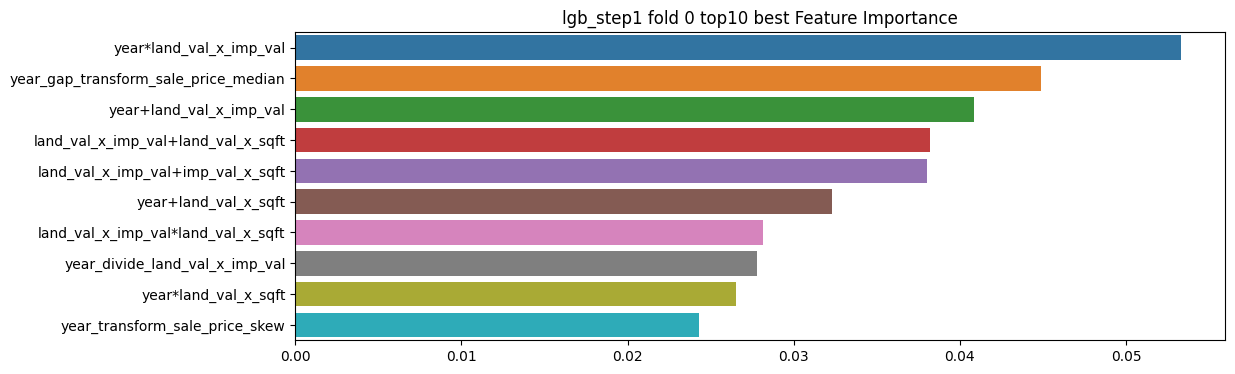

 20%|██        | 1/5 [08:09<32:39, 489.98s/it]

name:lgb_step1,fold:1
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.25782e+10	valid_0's rmse: 112152
[200]	valid_0's l2: 1.10489e+10	valid_0's rmse: 105114
[300]	valid_0's l2: 1.05649e+10	valid_0's rmse: 102786

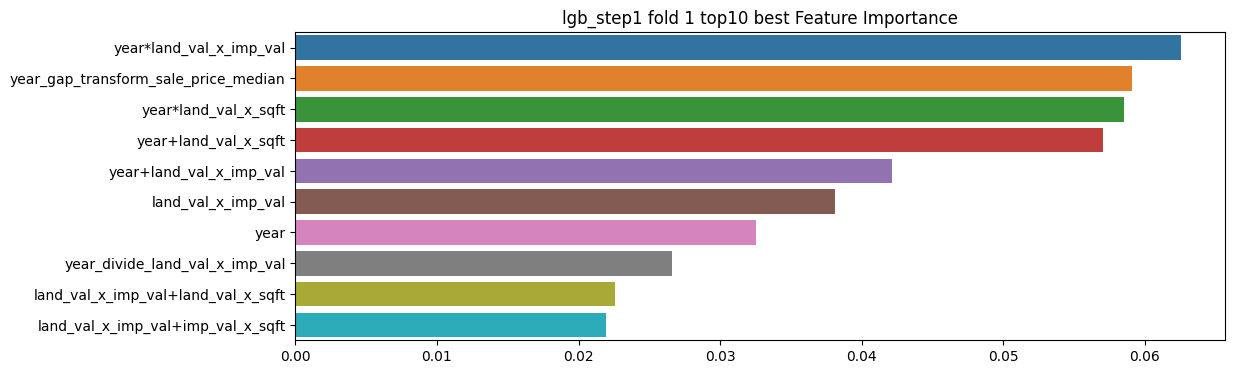

 40%|████      | 2/5 [16:38<25:02, 500.90s/it]

name:lgb_step1,fold:2
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.28838e+10	valid_0's rmse: 113507
[200]	valid_0's l2: 1.12572e+10	valid_0's rmse: 106100
[300]	valid_0's l2: 1.07605e+10	valid_0's rmse: 103733

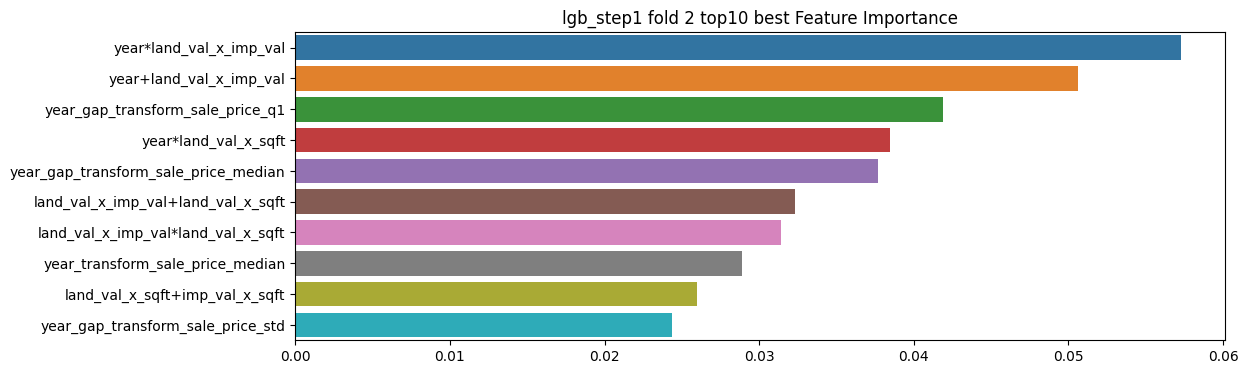

 60%|██████    | 3/5 [25:06<16:47, 503.95s/it]

name:lgb_step1,fold:3
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.2353e+10	valid_0's rmse: 111144
[200]	valid_0's l2: 1.09097e+10	valid_0's rmse: 104449
[300]	valid_0's l2: 1.04566e+10	valid_0's rmse: 102258


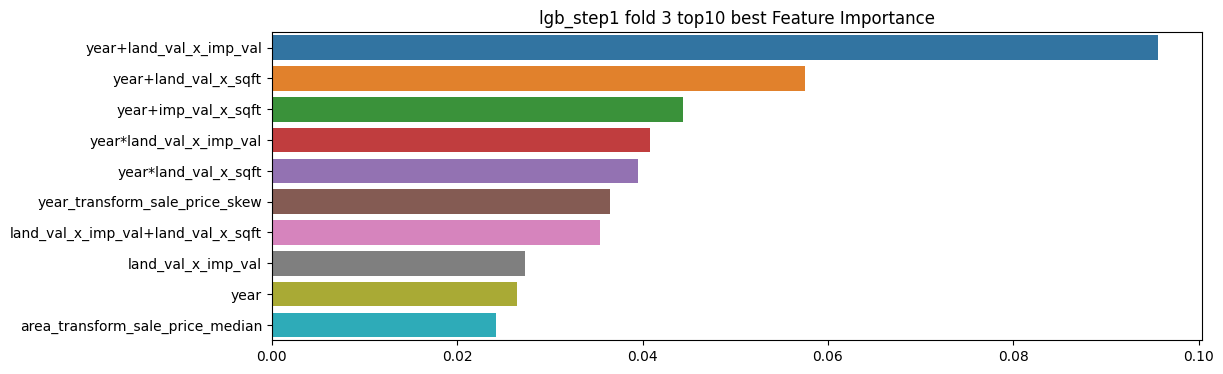

 80%|████████  | 4/5 [33:37<08:26, 506.79s/it]

name:lgb_step1,fold:4
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.31944e+10	valid_0's rmse: 114867
[200]	valid_0's l2: 1.16705e+10	valid_0's rmse: 108030
[300]	valid_0's l2: 1.12133e+10	valid_0's rmse: 105893

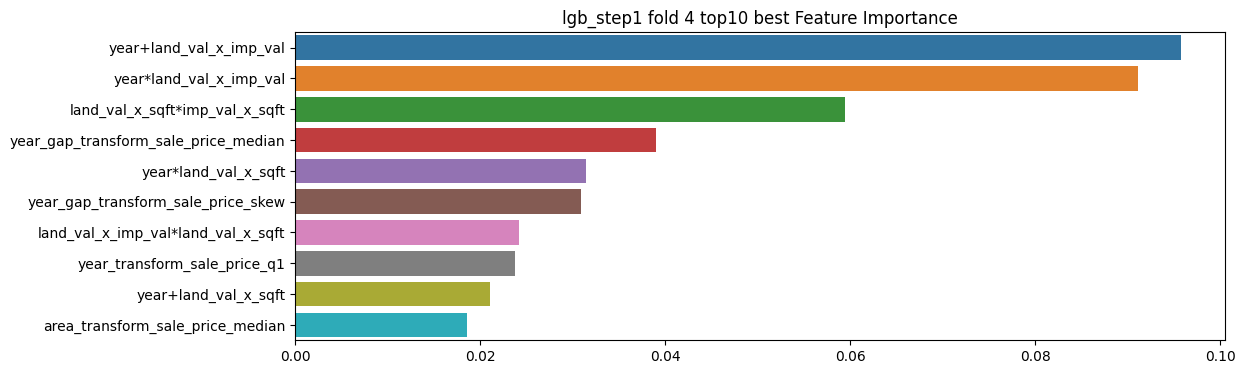

100%|██████████| 5/5 [42:16<00:00, 507.22s/it]


rmse------------------------------>100038.93963565218
predict......
weight normalization
weights:[1.]
final_repeat0_rmse:100038.93963565218
load test data
Feature Engineer


  0%|          | 0/7 [00:00<?, ?it/s]

-> for column city text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]

-> for column submarket text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

-> for column sale_date text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.17it/s]

-> for column zoning text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.14it/s]

-> for column join_status text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:04<00:01,  1.16it/s]

-> for column sale_warning text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [00:05<00:00,  1.17it/s]

-> for column subdivision text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


< one hot encoder >


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:[]
high_corr_cols:[]
------------------------------
test.shape:(200000, 169)
prediction on test data
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> fo

In [9]:
num_folds=5
n_estimators=1024
lgb_params={'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 
            'importance_type': 'gain', 'learning_rate': 0.05, 'max_depth': 15, 
            'min_child_samples': 30, 'min_child_weight': 0.01, 'min_split_gain': 0.002,
            'n_estimators': n_estimators, 'n_jobs': None, 'num_leaves': 125,
            'random_state': 2025, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.9, 
            'subsample_for_bin': 200000, 'subsample_freq': 0,
            'colsample_bynode': 0.6, 'verbose': -1, 'extra_trees': True, 'max_bin': 255, 
           }
    
yunbase=Yunbase(
    num_folds=num_folds,
    objective='regression',
    metric='rmse',
    models=[(LGBMRegressor(**lgb_params),'lgb_step1')],
    target_stat=target_stat,
    target_col='sale_price',
    cross_cols=['year','land_val_x_imp_val', 'land_val_x_sqft',  'imp_val_x_sqft'],
    word2vec_models=word2vec_models,
    plot_feature_importance=True,
)
yunbase.fit(train,category_cols=['subdivision','submarket','zoning','sale_warning','join_status','city'])
train['mean']=np.load(f"/kaggle/working/Yunbase_info/lgb_step1_seed2025_repeat0_fold{num_folds}_sale_price.npy")
test['mean']=yunbase.predict(test)

## Step2: Predict the `std`.

Currently supported metrics:['custom_metric', 'mae', 'rmse', 'mse', 'medae', 'rmsle', 'msle', 'mape', 'r2', 'smape', 'auc', 'pr_auc', 'logloss', 'f1_score', 'mcc', 'accuracy', 'multi_logloss']
Currently supported models:['lgb', 'cat', 'xgb', 'ridge', 'Lasso', 'LinearRegression', 'LogisticRegression', 'tabnet', 'Word2Vec', 'tfidfvec', 'countvec']
Currently supported kfolds:['KFold', 'GroupKFold', 'StratifiedKFold', 'StratifiedGroupKFold', 'purged_CV', 'custom_kfold']
Currently supported objectives:['binary', 'multi_class', 'regression']
fit......
load train data
Feature Engineer


  0%|          | 0/7 [00:00<?, ?it/s]

-> for column city text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:05,  1.19it/s]

-> for column submarket text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

-> for column sale_date text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]

-> for column zoning text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.18it/s]

-> for column join_status text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:04<00:01,  1.20it/s]

-> for column sale_warning text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [00:05<00:00,  1.19it/s]

-> for column subdivision text clean


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


< one hot encoder >


Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199992 [00:00<?, ?it/s]

< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:['sale_price']
high_corr_cols:[]
------------------------------
train.shape:(199992, 170)
feature_count:170
load models
lgb_step2_params:{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'gain', 'learning_rate': 0.05, 'max_depth': 15, 'min_child_samples': 30, 'min_child_weight': 0.01, 'min_split_gain': 0.002, 'n_estimators': 1024, 'n_jobs': None, 'num_leaves': 125, 'objective': None, 'random_state': 2025, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'colsample_bynode': 0.6, 'verbose': -1, 'extra_trees': True, 'max_bin': 255}
model training


  0%|          | 0/5 [00:00<?, ?it/s]

name:lgb_step2,fold:0
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.01665e+09	valid_0's rmsle: 1.22568
[200]	valid_0's l2: 3.99178e+09	valid_0's rmsle: 1.21844
[300]	valid_0's l2: 3.98775e+09	valid_0's rmsle: 1

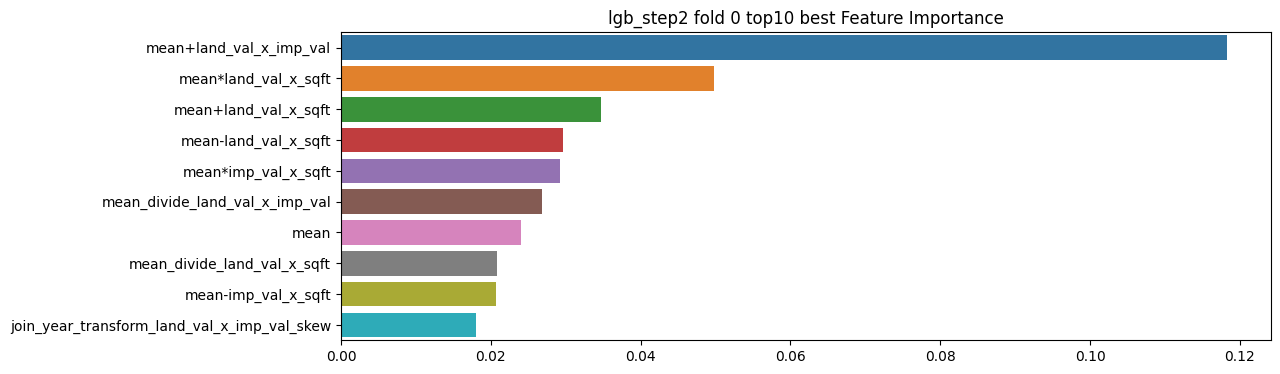

 20%|██        | 1/5 [04:43<18:54, 283.55s/it]

name:lgb_step2,fold:1
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.98438e+09	valid_0's rmsle: 1.22999
[200]	valid_0's l2: 3.98493e+09	valid_0's rmsle: 1.22293
Early stopping, best iteration is:
[137]	valid_0's

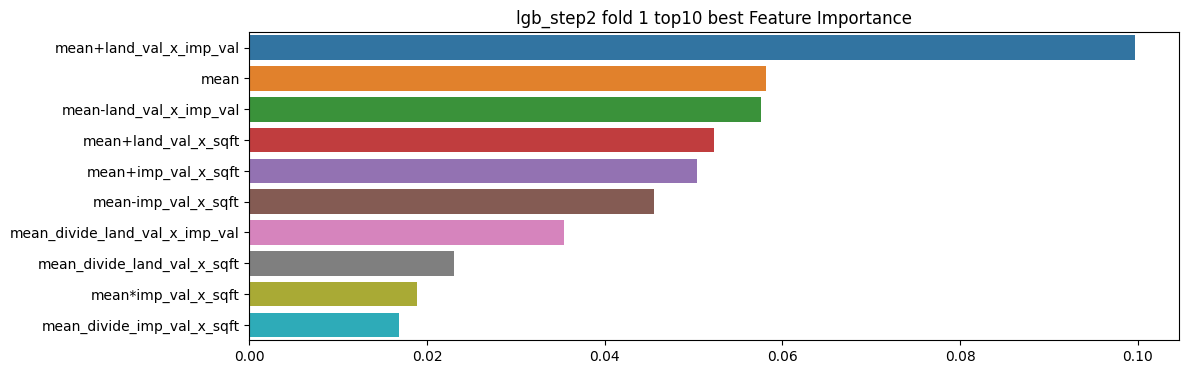

 40%|████      | 2/5 [08:37<12:43, 254.54s/it]

name:lgb_step2,fold:2
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.18902e+09	valid_0's rmsle: 1.23222
[200]	valid_0's l2: 4.17568e+09	valid_0's rmsle: 1.22494
[300]	valid_0's l2: 4.17357e+09	valid_0's rmsle: 1

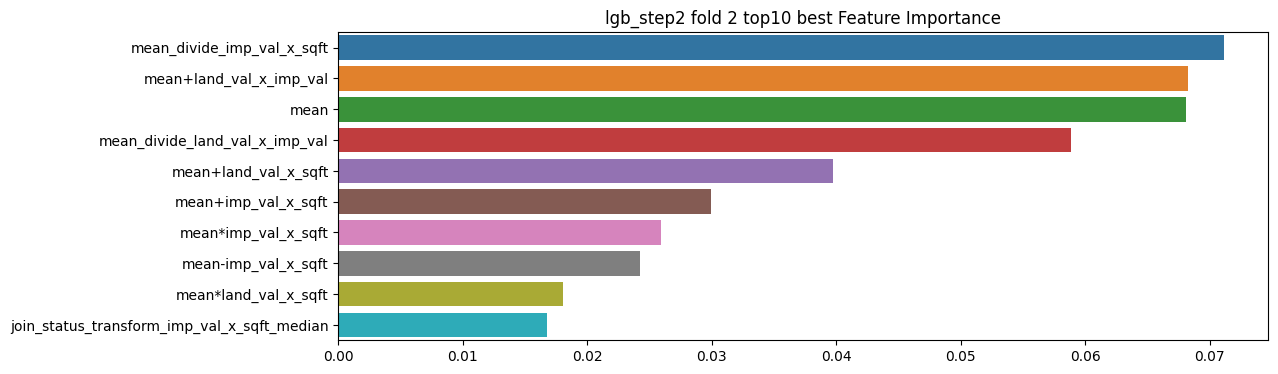

 60%|██████    | 3/5 [12:56<08:32, 256.34s/it]

name:lgb_step2,fold:3
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.04277e+09	valid_0's rmsle: 1.23456
[200]	valid_0's l2: 4.03462e+09	valid_0's rmsle: 1.22647
[300]	valid_0's l2: 4.03897e+09	valid_0's rmsle: 1

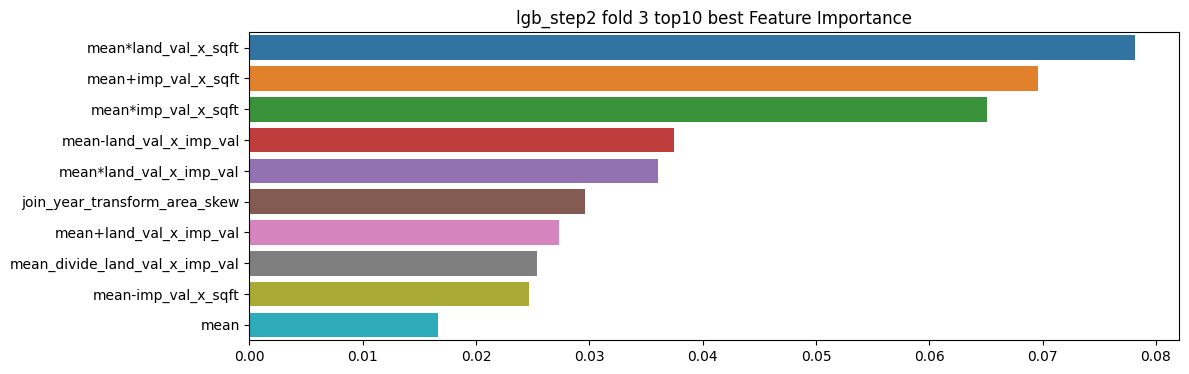

 80%|████████  | 4/5 [17:14<04:17, 257.16s/it]

name:lgb_step2,fold:4
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.20343e+09	valid_0's rmsle: 1.22217
[200]	valid_0's l2: 4.16899e+09	valid_0's rmsle: 1.21477
Early stopping, best iteration is:
[179]	valid_0's

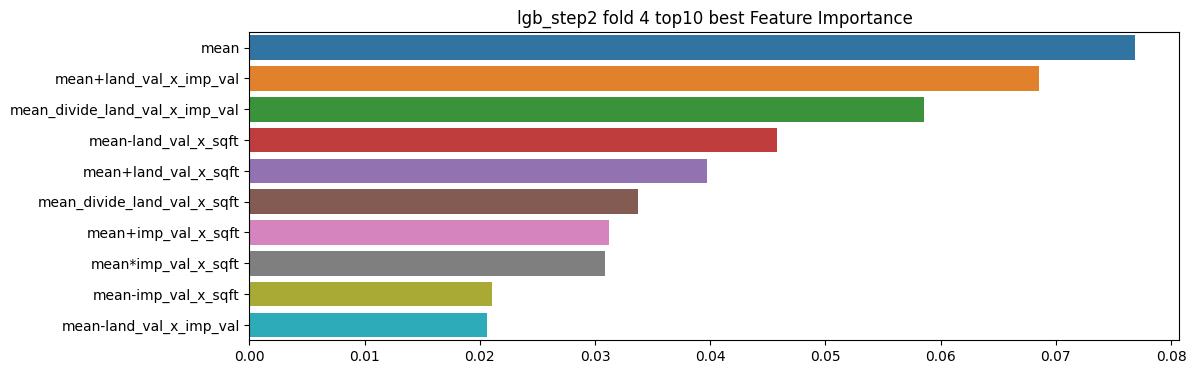

100%|██████████| 5/5 [21:29<00:00, 257.96s/it]


rmsle------------------------------>1.221511948845966
predict......
weight normalization
weights:[1.]
final_repeat0_rmsle:1.221511948845966
load test data
Feature Engineer


  0%|          | 0/7 [00:00<?, ?it/s]

-> for column city text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:05,  1.19it/s]

-> for column submarket text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

-> for column sale_date text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.16it/s]

-> for column zoning text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.15it/s]

-> for column join_status text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:04<00:01,  1.17it/s]

-> for column sale_warning text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [00:05<00:00,  1.18it/s]

-> for column subdivision text clean


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


< one hot encoder >


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:['sale_price']
high_corr_cols:[]
------------------------------
test.shape:(200000, 170)
prediction on test data
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec feature
-> for column sale_warning tfidf_char word2vec feature
-> for column join_status tfidf_char word2vec feature
-> for column city tfidf_char word2vec feature
-> for column zoning tfidf_char word2vec feature
-> for column subdivision tfidf_char word2vec feature
-> for column submarket tfidf_char word2vec feature
< word2vec >
-> for column sale_date tfidf_char word2vec f

In [10]:
train['target']=np.abs((train['sale_price']-train['mean']))
target_stat=[]
for c in CATS:
    for t in ['area','land_val_x_imp_val','land_val_x_sqft','imp_val_x_sqft','target']:
        if c!=t:
            target_stat.append(
                (c,t,STATS)
            )
yunbase=Yunbase(
    num_folds=num_folds,
    objective='regression',
    drop_cols=['sale_price'],
    metric='rmsle',
    models=[(LGBMRegressor(**lgb_params),'lgb_step2')],
    target_stat=target_stat,
    target_col='target',
    cross_cols=['mean','land_val_x_imp_val', 'land_val_x_sqft',  'imp_val_x_sqft'],
    word2vec_models=word2vec_models,
    plot_feature_importance=True,
)
yunbase.fit(train,category_cols=['subdivision','submarket','zoning','sale_warning','join_status','city'])
train['std']=np.load(f"/kaggle/working/Yunbase_info/lgb_step2_seed2025_repeat0_fold{num_folds}_target.npy")
test['std']=yunbase.predict(test)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">5.Model evaluation</h1></span>

Here, the optimal solution offline is found through parameter tuning.

In [11]:
def winkler_score(y_true, lower, upper, alpha=0.1, return_coverage=False):
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    return np.mean(score)
best_a,best_b,best_metric=200,200,310000
for a in range(200,230):
    for b in range(200,230):
        low=train['mean']-np.clip(train['std'],train['target'].min(),train['target'].max())*a/100
        high=train['mean']+np.clip(train['std'],train['target'].min(),train['target'].max())*b/100
        
        low=np.clip(low,true.min(),true.max())
        high=np.clip(high,true.min(),true.max())
        
        metric= winkler_score(true[train.index], low, high, alpha=0.1, return_coverage=True)
        if metric[0]<best_metric:
            best_metric=metric[0]
            best_a=a
            best_b=b
            print(best_a,best_b,best_metric)         

200 203 309931.5951511279
200 204 309806.18149407365
200 205 309687.7270367956
200 206 309576.67005985545
200 207 309473.13328103564
200 208 309377.6244118446
200 209 309291.0680019884
200 210 309211.8677772538
200 211 309139.43392560194
200 212 309075.65553831105
200 213 309020.7815161654
200 214 308974.1569640817
200 215 308935.2809847694
200 216 308904.3856229094
200 217 308880.39543443697
200 218 308862.9362129258
200 219 308852.2003049113
200 220 308848.1544109918


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">6.Submission</h1></span>

In [12]:
test_low=test['mean']-np.clip(test['std'],train['target'].min(),train['target'].max())*best_a/100
test_high=test['mean']+np.clip(test['std'],train['target'].min(),train['target'].max())*best_b/100
sub=pd.read_csv("/kaggle/input/prediction-interval-competition-ii-house-price/sample_submission.csv")
sub['pi_lower']=np.clip(test_low,true.min(),true.max())
sub['pi_upper']=np.clip(test_high,true.min(),true.max())
sub.to_csv("yunbase.csv",index=None)
sub.head()

,id,pi_lower,pi_upper
0,200000,791681.194344,1.012688e+06
1,200001,541145.339176,8.180654e+05
2,200002,434202.958983,6.657379e+05
3,200003,305011.786417,4.320282e+05
4,200004,290841.715985,7.109045e+05
